In [1]:
#import essential basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pprint import pprint

#import error quantifying metrics
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

#import data preprocessing modules
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#import all useful regression and ML models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
#We need to access modules from the project root, so we select this directory.
import os, sys

# Move 1 level up from notebooks/ to project root
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Importing and pre-processing

Collate price and explanatory variable data from 2023, 2024 and the first 6 months of 2025.

We will use 2023 and 2024 as model training data and attempt to predict the daily power price in 2025.

In [5]:
from data_import_functions import extract_data_from 

data = pd.concat([extract_data_from(2023), extract_data_from(2024), extract_data_from(2025)])

Data retrieved from frost.met.no!
Data retrieved from frost.met.no!
Data retrieved from frost.met.no!


Some quick data processing/cleaning.

In [7]:
data['prev_NO2'] = data['NO2'].shift(periods=1)
data = data.dropna().drop(columns = ['Week'])
data

,max(air_temperature P1D),mean(wind_speed P1D),sum(duration_of_sunshine P1D),DK1,GER,NL,NO2,UK,Gas Price,Reservoir stores,Storage anomaly,prev_NO2
2023-01-03,0.409302,2.275000,0.00,145.95,145.95,145.86,147.07,156.90,72.314003,21.066642,-2.043280,141.86
2023-01-04,2.151163,6.925000,0.00,58.94,58.94,99.89,109.08,120.81,65.022003,21.066642,-2.043280,147.07
2023-01-05,-1.544186,4.280000,0.00,107.46,107.46,118.96,134.51,144.58,72.421997,21.066642,-2.043280,109.08
2023-01-06,2.002326,5.040000,0.20,116.85,117.47,129.62,117.72,123.15,69.533997,21.066642,-2.043280,134.51
2023-01-07,4.597674,3.910000,0.00,88.81,88.81,86.35,95.02,113.06,69.533997,21.066642,-2.043280,117.72
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-11,16.876190,4.035000,14.50,70.83,71.60,79.46,68.32,94.71,35.912998,19.293028,-2.008381,60.87
2025-06-12,18.761905,3.336842,13.85,62.78,59.28,57.67,61.05,58.80,36.176998,19.293028,-2.008381,68.32
2025-06-13,19.545238,4.010000,11.90,51.03,52.09,72.22,56.50,97.67,37.894001,19.293028,-2.008381,61.05
2025-06-14,19.964286,3.975000,9.55,44.86,44.38,55.79,47.50,81.73,37.894001,19.293028,-2.008381,56.50


Making the train-test split: 2023/24 data for training, and save the 2025 data for testing.

In [9]:
all_data = data.copy()
all_data.sort_index(inplace=True)

train = all_data.loc['2023-01-03':'2024-12-31']
test = all_data.loc['2025-1-1':]

We measure model performance and goodness-of-fit using error parameters: root mean squared error (RMSE), and mean absolute error (MAE).

We define a function below to calculate these metrics for a general model.

In [11]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

#y_obs represents the observed values of the target variable
#y_hat represents the fitted/predicted values
def error_calc(y_obs, y_hat):
    error_dict = {'RMSE': np.sqrt(mse(y_obs, y_hat)),
                  'MAE': mae(y_obs, y_hat),
                 }
    return error_dict

## ML for initial fitting

Separate the target from the explanatory variables for both the train and test sets.

In [14]:
X_train = train.copy()
y_train = X_train.pop('NO2')

X_test = test.copy()
y_test = X_test.pop('NO2')

We define a generic class for regression models in source.fitting_model.model.

Attributes of this class include the preprocessing pipeline; a dictionary including error measures, which we use to compare different models; details of each specific model itself.

In [16]:
default_preprocess = ColumnTransformer(transformers = [('standardisation', pp.StandardScaler(), X_train.columns.drop(['DK1','GER','NL','UK','prev_NO2']))], remainder = 'passthrough')

class model():
    def __init__(self, name, model_steps, preprocesses = [('preprocess', default_preprocess)]):
        self.name = name
        self.error_dict = {}
        self.fit_model(model_steps, preprocesses)

    def fit_model(self, model_steps, preprocesses):
        pipeline = Pipeline(steps = preprocesses + [('model', model_steps)])
        pipeline.fit(X_train, y_train)
        self.y_fitted = pipeline.predict(X_train)
        self.y_hat = pipeline.predict(X_test)

        self.error_dict = {'R': pipeline.score(X_test, y_test),
                           'RMSE': np.sqrt(mse(y_test, self.y_hat)),
                           'MAE': mae(y_test, self.y_hat)
                           }  
        
    def plot_fit(self):
        plt.plot(X_test.index, self.y_hat, label = self.name) 

Define all models.

In [18]:
linear_preprocess = [('lin_preprocess', pp.StandardScaler()), ('PCA', PCA())]
linear = model('Linear', LinearRegression(), preprocesses = linear_preprocess)
ridge = model('Ridge', Ridge())
lasso = model('Lasso', Lasso())
random_forest1 = model('RF1', RandomForestRegressor(n_estimators=700, max_depth=6, random_state = 100))

               R       RMSE        MAE
Linear  0.702393  14.626245  11.050295
Ridge   0.702415  14.625715  11.047712
Lasso   0.705784  14.542685  10.926540
RF1     0.604027  16.871128  11.092689


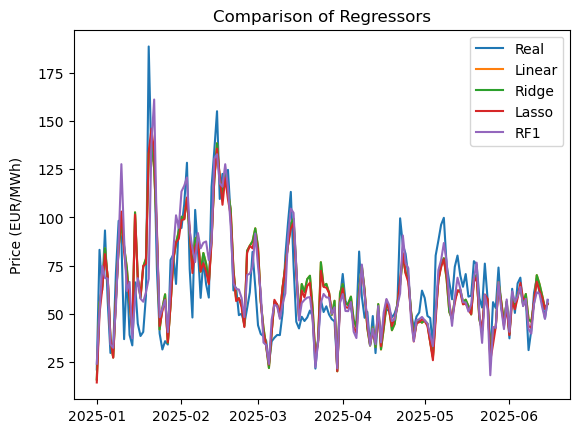

In [19]:
model_list = [linear, ridge, lasso, random_forest1]

model_dict = {}
plt.plot(y_test.index, y_test, label='Real')
for regressor in model_list:
    regressor.plot_fit()
    model_dict[regressor.name] = regressor.error_dict
plt.legend()
plt.ylabel("Price (EUR/MWh)", labelpad=10.0)
plt.title("Comparison of Regressors")
print(pd.DataFrame(model_dict).T)

In [20]:
#function for comparing fitted data with real data with an option to plot for visual analysis
#typically this function is used to compare test data, but sometimes we may wish to compare training data - the dataset to be analysed can be chosen by setting the 'training' parameter
def comparison_df(model, training = False, plot = False):
    df = pd.DataFrame(y_train) if training else pd.DataFrame(y_test)
    df['ML_preds'] = model.y_fitted if training else model.y_hat
    df['Residuals'] = df['NO2'] - df['ML_preds']

    if plot == True:
        fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw={'height_ratios': [2, 0.9], 'hspace': 0}, figsize = (7, 6))
        ax1.plot(df['NO2'], label='Real')
        ax1.plot(df['ML_preds'], label=model.name)
        ax1.legend()
        ax1.label_outer() 
        ax1.set_ylabel("Price (EUR/MWh)", labelpad=10.0)

        title = "ML Fitted Training Data" if training else "ML Predictions for Test Data"
        ax1.set_title(title)
        
        ax2.plot(df['Residuals'], color = 'green', label = 'Residuals')
        ax2.legend()
        ax2.set_ylabel("Residuals")
    return df
        

Creating a DataFrame of actual vs. predicted results and the residuals.

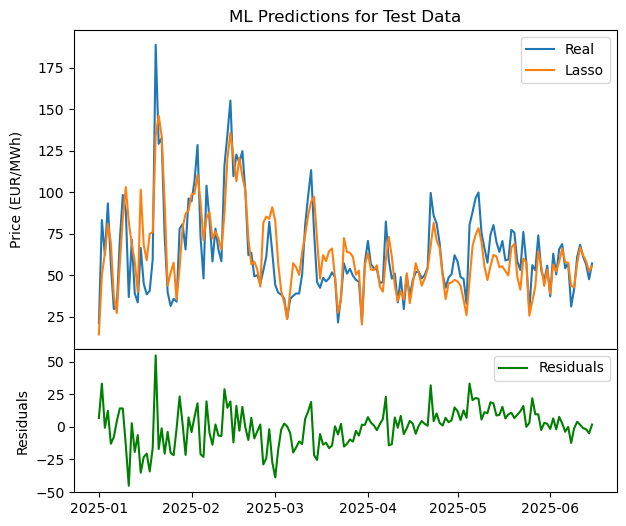

In [22]:
ML_results = comparison_df(lasso, plot = True)

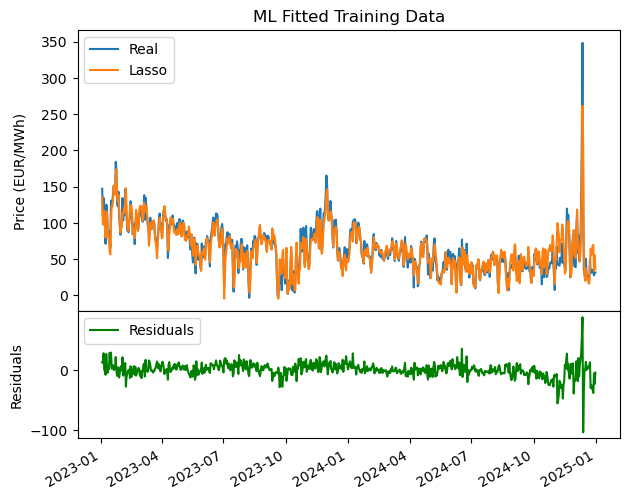

In [23]:
ML_fit = comparison_df(lasso, training = True, plot = True)
plt.gcf().autofmt_xdate()

## SARIMA on ML residuals

In [25]:
#importing relevant modules for time series regression, residual analysis and SARIMA fitting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX

We now fit the residuals of the training set with a SARIMA model to further reduce the errors in our model. We look to eliminate any autoregressive or seasonal behaviour that may show up in the errors.

In [27]:
sarima_training_data = ML_fit['Residuals']
sarima_training_data.index = sarima_training_data.index.to_period('D')

target = ML_results['Residuals']
target.index = target.index.to_period('D')

In [28]:
#define a function to calculate and plot the ACF and PACF profiles of a time series - we will make a lot of these...
def acf_pacf(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF on the left
    plot_acf(data, ax=axes[0])
    axes[0].set_title("Autocorrelation (ACF)")
    
    # PACF on the right
    plot_pacf(data, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation (PACF)")
    
    #plt.tight_layout()
    plt.show()

(-3.660822815024715,
 0.0046992071333137805,
 13,
 715,
 {'1%': -3.4395289262948894,
  '10%': -2.5689271030368235,
  '5%': -2.8655907692307694},
 5333.583300035389)


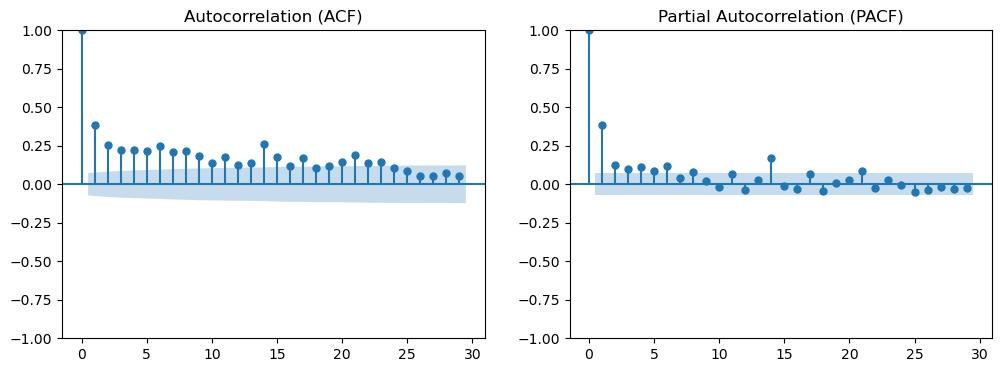

In [29]:
pprint(adfuller(sarima_training_data))
acf_pacf(sarima_training_data)

In [30]:
res_sarima = SARIMAX(sarima_training_data, order = (1,0,2), seasonal_order = (1,0,1,7)).fit()
print(res_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Residuals   No. Observations:                  729
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -2743.911
Date:                             Thu, 11 Sep 2025   AIC                           5499.821
Time:                                     11:26:26   BIC                           5527.372
Sample:                                 01-03-2023   HQIC                          5510.451
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9613      0.017     57.450      0.000       0.928       0.994
ma.L1         -0.6923      

Use our fitted SARIMA model to predict the residuals of the test set as an updating time series. Note that we ensure that, as the model forecasts the next day's residual value, it continually retrains itself by taking the current day's data into account (this is achieved by setting parameter 'refit = True'). 

This mimics real trading as, when predicting tomorrow's day ahead price, today's price is available. More technically, conditional expectations for future values are calculated given current day's filtration.

In [32]:
res_forecasts = []
for t in range(len(target)):
    forecast = res_sarima.get_forecast(steps = 1)
    res_forecasts.append(forecast.predicted_mean.iloc[0])
    new_obs = target.iloc[t:t+1]
    res_sarima = res_sarima.append(new_obs, refit = True)

We now combine our ML results and our SARIMA-fitted residuals to obtain final predictions for the test set.

Text(0, 0.5, 'Residuals')

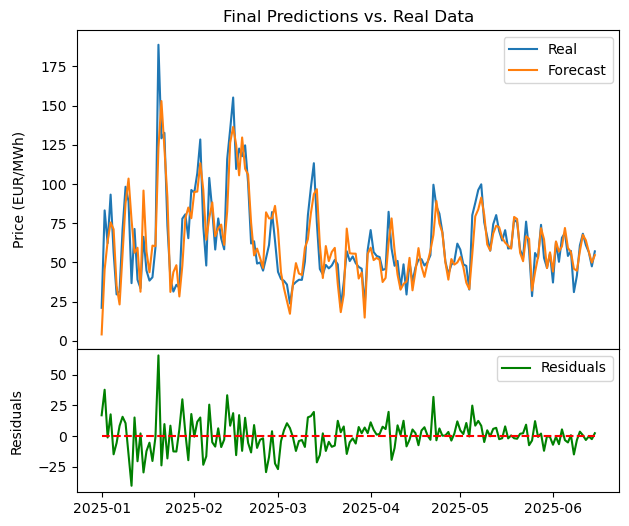

In [34]:
total_preds = ML_results.copy()
total_preds['SARIMA_errors'] = res_forecasts
total_preds['Forecast'] = total_preds['ML_preds'] + total_preds['SARIMA_errors']
total_preds['Residuals'] = total_preds['NO2'] - total_preds['Forecast']

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, gridspec_kw={'height_ratios': [2, 0.9], 'hspace': 0}, figsize = (7, 6))
ax1.plot(total_preds['NO2'], label='Real')
ax1.plot(total_preds['Forecast'], label='Forecast')
ax1.legend()

ax2.plot(total_preds['Residuals'], label = 'Residuals', color = 'green')
ax2.legend()

#constructing a zero line for the residuals plot
dt1 = np.datetime64(dt.datetime(2025,1,1))
dt2 = np.datetime64(dt.datetime(2025,6,15))
ax2.plot([dt1, dt2], [0,0], linestyle = '--', color = 'red')

ax1.set_ylabel("Price (EUR/MWh)",labelpad=10.0)
ax1.set_title("Final Predictions vs. Real Data")
ax2.set_ylabel("Residuals",labelpad=10.0)

In [35]:
error_calc(total_preds['NO2'], total_preds['Forecast'])

{'RMSE': 13.243084376992922, 'MAE': 9.523628354808467}

## Investigating final residuals

For the final residuals, we perform an Augmented Dickey-Fuller test and check their ACF and PACF to ensure that there is no leftover SARIMA properties, which should have all been mopped up by the above time series fitting. We observe that this is roughly the case.

(-13.394273652029659,
 4.700926261903256e-25,
 0,
 165,
 {'1%': -3.470616369591229,
  '10%': -2.57619681359045,
  '5%': -2.8792214018977655},
 1190.9393613565835)


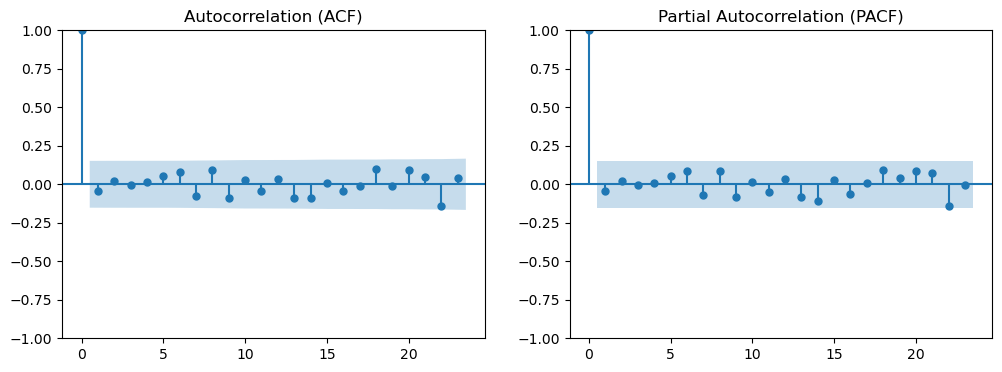

In [38]:
residual_data = total_preds['Residuals']
pprint(adfuller(residual_data))
acf_pacf(residual_data)

We plot the final residuals as a histogram and overlay a normal distribution for reference. We test whether our residuals have white noise properties. We observe fat tails and slight positive skew which is indicative of price spikes.

Text(0, 0.5, 'Frequency Density')

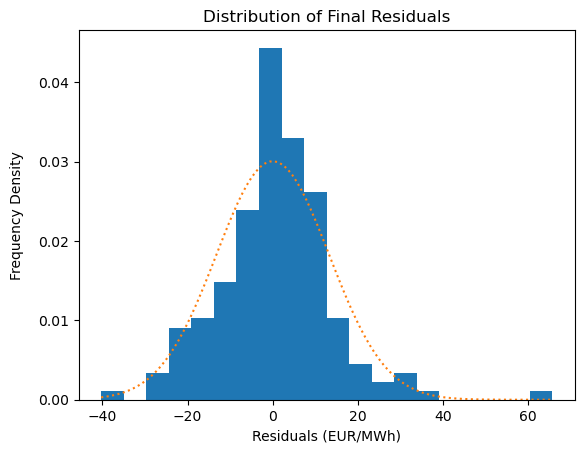

In [40]:
res_stdev = residual_data.std()

res_range = np.linspace(residual_data.min(), residual_data.max(), 100)
normal_overlay = norm.pdf(res_range, 0, res_stdev)

plt.hist(residual_data, 
         bins = 20,
         density = True)
plt.plot(res_range, normal_overlay, linestyle = ':')
plt.title("Distribution of Final Residuals")
plt.xlabel("Residuals (EUR/MWh)")
plt.ylabel("Frequency Density", labelpad=10.0)